In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'week9/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
import os, glob

print("CWD:", os.getcwd())
data_dir = r'week9/hymenoptera_data'  # 필요하면 절대경로로 바꾸세요. 예: r'C:\Users\...\week9\hymenoptera_data'
for split in ['train','val']:
    p = os.path.join(data_dir, split)
    print(split, "exists:", os.path.isdir(p), "=>", p)
    if os.path.isdir(p):
        print("dirs under", split, ":", [d for d in os.listdir(p)])


CWD: C:\Users\pc\pytorchAI
train exists: True => week9/hymenoptera_data\train
dirs under train : ['ants', 'bees']
val exists: True => week9/hymenoptera_data\val
dirs under val : ['ants', 'bees']


In [4]:
import os, shutil

data_dir = r'week9/hymenoptera_data'  # 위와 동일하게
removed = []
for split in ['train','val']:
    root = os.path.join(data_dir, split)
    if not os.path.isdir(root): 
        continue
    for cur, dirs, files in os.walk(root):
        for d in list(dirs):
            if d == '.ipynb_checkpoints':
                full = os.path.join(cur, d)
                shutil.rmtree(full, ignore_errors=True)
                removed.append(full)
print("removed:", removed if removed else "none")


removed: none


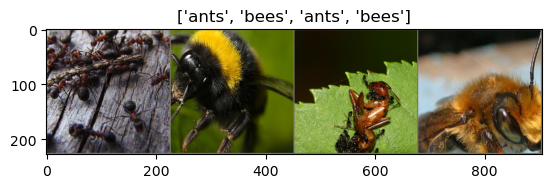

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)  # ← 필요한 부분만 수정

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6155 Acc: 0.6516
val Loss: 0.4707 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5115 Acc: 0.7623
val Loss: 0.3724 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4107 Acc: 0.8525
val Loss: 0.3456 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.3563 Acc: 0.8484
val Loss: 0.2859 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3866 Acc: 0.8566
val Loss: 0.2734 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3518 Acc: 0.8402
val Loss: 0.2649 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.3368 Acc: 0.8730
val Loss: 0.2434 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2962 Acc: 0.8689
val Loss: 0.2306 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2805 Acc: 0.8770
val Loss: 0.2402 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3380 Acc: 0.8443
val Loss: 0.2344 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3251 Acc: 0.8566
val Loss: 0.2315 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3391 Acc: 0.8607
val Loss: 0.2217 Acc: 0.9281

Ep

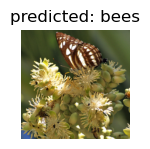

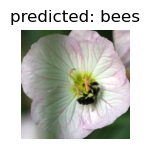

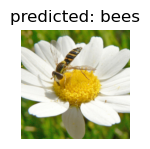

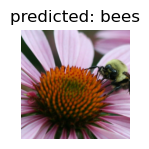

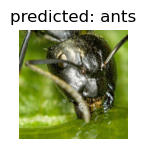

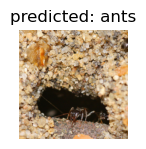

In [10]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# 필요한 부분만 수정
in_ftrs = model_conv.classifier[-1].in_features
model_conv.classifier[-1] = nn.Linear(in_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 최종 레이어만 최적화
optimizer_conv = optim.SGD(model_conv.classifier[-1].parameters(), lr=0.001, momentum=0.9)

# 스케줄러 유지
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6528 Acc: 0.5984
val Loss: 0.5095 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.4834 Acc: 0.8115
val Loss: 0.4020 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4540 Acc: 0.7992
val Loss: 0.3561 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4042 Acc: 0.8197
val Loss: 0.3450 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.3944 Acc: 0.8320
val Loss: 0.3123 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4044 Acc: 0.8443
val Loss: 0.2820 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4068 Acc: 0.8279
val Loss: 0.2982 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3512 Acc: 0.8607
val Loss: 0.2729 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3610 Acc: 0.8484
val Loss: 0.2932 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3866 Acc: 0.8279
val Loss: 0.2737 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3075 Acc: 0.8811
val Loss: 0.2865 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3577 Acc: 0.8279
val Loss: 0.2833 Acc: 0.9412

Ep

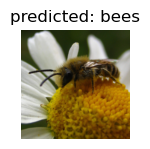

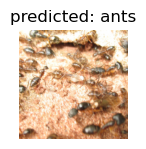

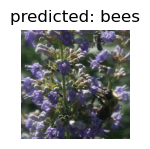

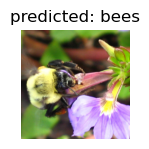

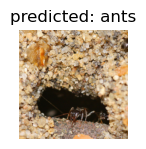

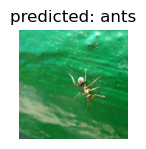

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()